In [1]:
#Import libraries:
import tweepy
import json
import pandas as pd
import codecs
import re
import string
from sys import argv

In [2]:
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob

In [3]:
### Initial nltk installation:
### from ipython: import nltk --> nltk.download() --> select Corpora - wordnet
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import TweetTokenizer

In [66]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
from pandas import Series

## Define Keywords for Data Analysis

In [223]:
key_1 = "#pizza"
key_2 = "#yoga"
today = "2018-04-17" 

file_1 = key_1 + "-" + today + ".csv"
file_2 = key_2 + "-" + today + ".csv"
print("file 1:",file_1)
print("file 2:",file_2)

file 1: #pizza-2018-04-17.csv
file 2: #yoga-2018-04-17.csv


In [224]:
columns = ['date','favorites','id','retweets','source','text','user_flwr_count','user_name']
data_1 = pd.read_csv(file_1,header = None,names = columns,parse_dates=['date'],dtype={'id':str,'favorites':int,'retweets':int,'user_flwr_count':int})
data_2 = pd.read_csv(file_2,header = None,names = columns,parse_dates=['date'],dtype={'id':str,'favorites':int,'retweets':int,'user_flwr_count':int})

In [225]:
data_1.tail(2)

,date,favorites,id,retweets,source,text,user_flwr_count,user_name
9998,2018-04-11 03:15:42,0,983906408801292289,0,Instagram,"Yes, I am tracing this #AMAZING #ChickenAlfred...",1485,Jeremy Petrachonis
9999,2018-04-11 03:15:34,0,983906373732745221,1,Beer and Pizza - Rewteet,RT @party_on_cheers: Join 7 people right now a...,2755,Beer and Pizza Day!


In [226]:
data_2.tail(2)

,date,favorites,id,retweets,source,text,user_flwr_count,user_name
9998,2018-04-14 10:31:53,0,985103341406621697,0,Social Rabbit 307,#yoga Capezio Girls' Children's Collection Pul...,401,My Yoga Time
9999,2018-04-14 10:31:53,0,985103339796025344,0,Perkville,So #grateful we could still do #yoga together....,33,Emma Haffey


## Calculate Counts

In [302]:
def tweet_metrics(data, keyword):
    # Create list of dates:
    data['type'] = keyword
    #data['calendar_day'] = data['date'].apply(lambda x: x.strftime('%Y-%m-%d'))
    #dates = sorted(list(set(data['calendar_day'])))

    # Initialize Time Series DataFrame

    #get total number of tweets by day from raw tweet data
    tweets_by_type = data.groupby('type')['type'].agg('count')

    #get number of followers
    followers_per_type = data.groupby('type')['user_flwr_count'].agg('sum')

    #get number of favorites
    favorites_per_type = data.groupby('type')['favorites'].agg('sum')

    #get number of retweetshours_1 = round((data_1['date'][0] - data_1['date'][999]).seconds/3600, 2)
    retweets_per_type = data.groupby('type')['retweets'].agg('sum')
    
    summary = pd.DataFrame()
    summary['Total Tweets'] = list(tweets_by_type)
    summary['Favorites'] = list(favorites_per_type)	
    summary['Retweets'] = list(retweets_per_type)
    summary['Followers'] = list(followers_per_type)
    
    return(summary)

In [303]:
def time_count(data, summary):
    #number of hours to collect the tweets
    last_tweet = summary['Total Tweets'][0] - 1
    time_delta = data['date'][0] - data['date'][last_tweet]
    hours = round(time_delta.seconds/3600, 2) + time_delta.days * 24
    
    time_compare = pd.DataFrame()
    time_compare['Total Tweets'] = summary['Total Tweets']
    time_compare['Hours to Collect'] = hours
    
    return(time_compare)

In [304]:
def tweet_sentiments(data, summary):    
    #Using TextBlob senttiment.polarity module on raw tweet data to determine sentiment polarity. 
    #Produce list of dictionaries "tweets_with_sent".
    #analyze tweets sentiments and count number of tweets.
    tweets_with_sent = []
    pos_tweets=0
    neg_tweets=0
    neu_tweets=0

    for tweet_text in data['text']:
        tmp = TextBlob(tweet_text).sentiment.polarity
        if tmp > 0:
            add_sentiment = 'positive'
            pos_tweets += 1
        elif tmp == 0:
            add_sentiment = 'neutral'
            neu_tweets += 1
        else:
            add_sentiment = 'negative'
            neg_tweets += 1
        
        #appending parsed tweet to list
        tweets_with_sent.append(add_sentiment)
    
    #prepare dataset for modeling - add "sentiment" column to the tweets dataframe
    data['sentiment'] = tweets_with_sent

    #the last function unstack() spreads sentiment values across as columns
    sentiment_df = data.groupby(['type','sentiment'])['type'].agg('count').unstack().fillna(0).astype(int)

    #add sentiments to time series dataframe:
    summary['Neutral'] = list(sentiment_df['neutral'])
    summary['Positive'] = list(sentiment_df['positive'])
    summary['Negative'] = list(sentiment_df['negative'])
    
    return(summary)

In [305]:
summary_1 = tweet_metrics(data_1, key_1)
summary_1 = tweet_sentiments(data_1, summary_1)
summary_1

,Total Tweets,Favorites,Retweets,Followers,Neutral,Positive,Negative
0,10000,9164,663020,68106141,3654,5432,914


In [306]:
summary_2 = tweet_metrics(data_2, key_2)
summary_2 = tweet_sentiments(data_2, summary_2)
summary_2

,Total Tweets,Favorites,Retweets,Followers,Neutral,Positive,Negative
0,10000,12763,117819,89310678,4451,4766,783


In [307]:
summary = summary_1.append(summary_2)
norm = summary/summary_1
compare_tweets = norm.transpose()
compare_tweets.columns = [key_1, key_2]
compare_tweets

,#pizza,#yoga
Total Tweets,1.0,1.000000
Favorites,1.0,1.392732
Retweets,1.0,0.177701
Followers,1.0,1.311345
Neutral,1.0,1.218117
Positive,1.0,0.877393
Negative,1.0,0.856674


## Visualize

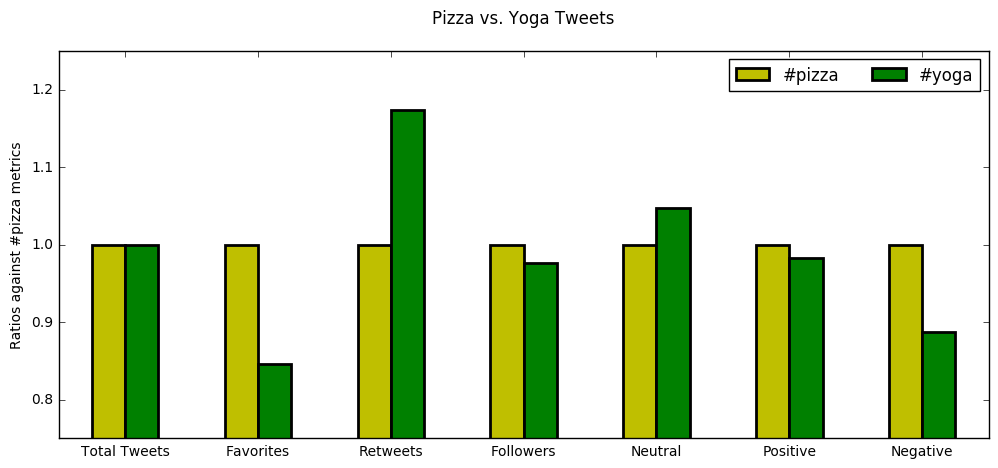

In [221]:
#old visualization for 1,000 tweets
fig,ax1 = plt.subplots(figsize=(12,5))
compare_tweets.plot(ax=ax1,kind='bar',linewidth='2',rot=0,color='yg')
ax1.set_ylabel("Ratios against " + key_1 + " metrics")
ax1.set_ylim([0.75,1.25])
ax1.legend(loc='best',ncol=2)
ax1.set_title("Pizza vs. Yoga Tweets\n")
fig.savefig("pizza-vs-yoga-" + today + ".png")

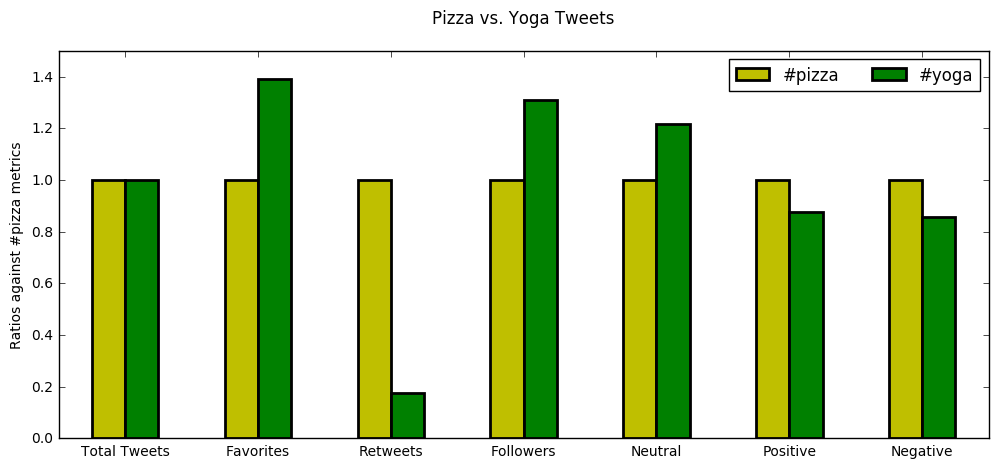

In [308]:
fig,ax1 = plt.subplots(figsize=(12,5))
compare_tweets.plot(ax=ax1,kind='bar',linewidth='2',rot=0,color='yg')
ax1.set_ylabel("Ratios against " + key_1 + " metrics")
ax1.set_ylim([0,1.5])
#ax1.set_xlabel('Metrics')
ax1.legend(loc='best',ncol=2)
ax1.set_title("Pizza vs. Yoga Tweets\n")
fig.savefig("pizza-vs-yoga-" + today + ".png")

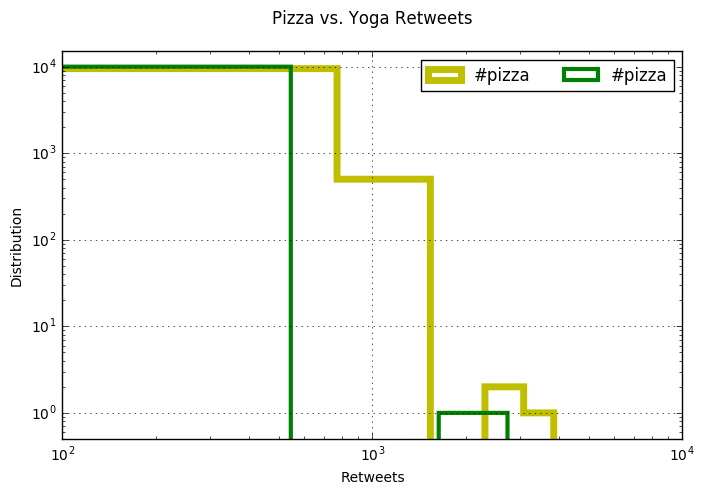

In [309]:
fig,ax1 = plt.subplots(figsize=(8,5))
data_1['retweets'].hist(ax=ax1, color='y', histtype ='step', linewidth = 5, label = key_1, bins = 5)
data_2['retweets'].hist(ax=ax1, color='g', histtype ='step', linewidth = 3, label = key_1, bins = 5)
plt.xscale('log')
plt.yscale('log')
ax1.set_ylabel("Distribution")
ax1.set_xlabel('Retweets')
ax1.set_ylim([0.5,15000])
ax1.legend(loc='best',ncol=2)
ax1.set_title("Pizza vs. Yoga Retweets\n")
fig.savefig("pizza-vs-yoga-retweets-" + today + ".png")

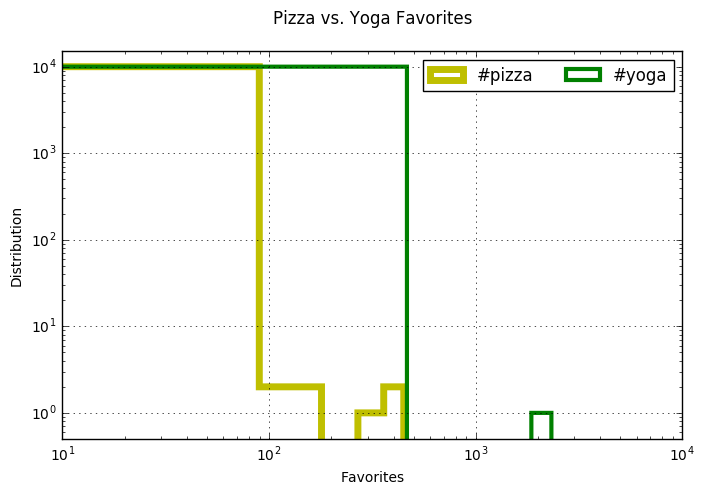

In [310]:
fig,ax1 = plt.subplots(figsize=(8,5))
data_1['favorites'].hist(ax=ax1, color='y', histtype ='step', linewidth = 5, label = key_1, bins = 5)
data_2['favorites'].hist(ax=ax1, color='g', histtype ='step', linewidth = 3, label = key_2, bins = 5)
plt.xscale('log')
plt.yscale('log')
ax1.set_ylabel("Distribution")
ax1.set_xlabel('Favorites')
ax1.set_ylim([0.5,15000])
ax1.legend(loc='best',ncol=2)
ax1.set_title("Pizza vs. Yoga Favorites\n")
fig.savefig("pizza-vs-yoga-favorites-" + today + ".png")

## Calculate time count to collect each set of tweets

In [311]:
time_1 = time_count(data_1, summary_1)
time_2 = time_count(data_2, summary_2)
timec = time_1.append(time_2)
timec.index = [key_1, key_2]
timec

,Total Tweets,Hours to Collect
#pizza,10000,140.73
#yoga,10000,61.46


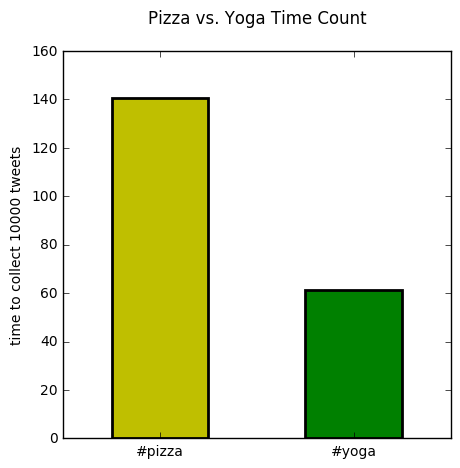

In [313]:
fig,ax1 = plt.subplots(figsize=(5,5))
timec['Hours to Collect'].plot(ax=ax1,kind='bar',linewidth='2',rot = 0, color='yg')
ax1.set_ylabel("time to collect " + str(timec['Total Tweets'][0]) + " tweets")
ax1.set_title("Pizza vs. Yoga Time Count\n")
fig.savefig("pizza-vs-yoga-time-count-" + today + ".png")